# Time-inhomogeneous coalescent

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
#devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
# Rcpp::sourceCpp("./timeinhom-kingman.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

## Generate state space in R

In [51]:
kingman <- function(state, n, graph=NULL) {
    
  # states <- c()
  # rates <- c()
  states <- list()
  rates <- list()

  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {

      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next; # an absorbing state that is not the last state
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }

      # copy state
      child_state <- state
        
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1

     states[[length(states)+1]] = child_state
     rates[[length(rates)+1]] = rate
    }
  }
  return(list("states" = states, "rates" = rates)) 
}

n <- 4

graph <- create_graph(n)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)

trans <- kingman(c(2, 1, 0, 0), n)
for (i in 1:length(trans$states)) {
    state <- unlist(trans$states[i])
    rate <- unlist(trans$rates[i])
    cat("state:", state, "rate:", rate, "\n")
}

state: 0 2 0 0 rate: 1 
state: 1 0 1 0 rate: 2 


In [52]:
state_space <- function(initial_state, fun, ...) {
    
    graph <- create_graph(length(initial_state))
    starting_vertex <- vertex_at(graph, 1)
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      print(c(index, vertices_length(graph)))
      vertex <- vertex_at(graph, index)
      state <- vertex$state

      result <- fun(state, graph=graph, ...)

      if (length(result$states) > 0) {
        for (i in 1:length(result$states)) {
            add_edge(
              vertex,
              find_or_create_vertex(graph, c(result$states[[i]])),
              c(result$rates[[i]]), c(result$rates[[i]])
            )
        }
      }
      index <- index + 1
   }
   return(graph)
}



# just give the state_space function an initial state, 
# a callback function and any arguments the callback function
# that takes a "state" and "graph" argument and any other
# arguments passed state_space:

n <- 4
initial_state = rep(0, n)
initial_state[1] <- n

graph <- state_space(initial_state, kingman, n)
graph

[1] 2 2
[1] 3 3
[1] 4 5
[1] 5 6
[1] 6 6


<pointer: 0x600003db8000>

In [48]:
graph_as_matrix(graph)

4,0,0,0
2,1,0,0
0,2,0,0
1,0,1,0
-6,6,0,0
0,-3,1,2
0,0,-1,0
0,0,0,-1


In [ ]:
   
# standard_coalescent <- function(n, size, graph=NULL, edge_trans=NULL, epoque=0) {

#     state_vector_length <- n + 1

#     if (is.null(graph)) {
    
#         graph <- create_graph(state_vector_length)
#         starting_vertex <- vertex_at(graph, 1)
#         initial_state <- c(rep(0, n), epoque)
#         initial_state[1] <- n
        
#         add_edge(
#           starting_vertex,
#           create_vertex(graph, initial_state),
#           1
#         )
#         index <- 2
        
#     } else {
#         nr_states <- vertices_length(graph)
#         for (i in 2:(nr_states-1)) {
#             if (is.nan(edge_trans[i-1])) {
#                 next;
#             }
#             vertex <- vertex_at(graph, i)
#             state <- vertex$state
#             sister_state <- state
#             sister_state[length(sister_state)] <- epoque
#             add_edge(
#               vertex,
#               find_or_create_vertex(graph, sister_state),
#               edge_trans[i-1], c(edge_trans[i-1]) # -1 becuase first index is 2 and first element of edge_trans is 1
#             )
#         }
#         index <- nr_states + 1
#     }

#     while (index <= vertices_length(graph)) {
#       vertex <- vertex_at(graph, index)

#       state <- vertex$state
#       result <- state_space(state, graph)
#       for (i in 1:length(result)) {
#           add_edge(
#               vertex,
#               find_or_create_vertex(graph, result$states[i]),
#               result$rates[i], c(result$rates[i])
#             )
#       }
#       index <- index + 1
#     }
#     if (epoque == 0) {
#         return(graph)
#     }
# }

# add_epoque <- function(n, size, graph, epoque_trans, epoque)
#     return(standard_coalescent(n, size, graph, epoque_trans, epoque))

# graph <- standard_coalescent(4, 1)
# graph_as_matrix(graph)

In [13]:
standard_coalescent <- function(n, size, graph=NULL, edge_trans=NULL, epoque=0) {

    state_vector_length <- n + 1

    if (is.null(graph)) {
    
        graph <- create_graph(state_vector_length)
        starting_vertex <- vertex_at(graph, 1)
        initial_state <- c(rep(0, n), epoque)
        initial_state[1] <- n
        
        add_edge(
          starting_vertex,
          create_vertex(graph, initial_state),
          1
        )
        index <- 2
        
    } else {
        nr_states <- vertices_length(graph)
        for (i in 2:(nr_states-1)) {
            if (is.nan(edge_trans[i-1])) {
                next;
            }
            vertex <- vertex_at(graph, i)
            state <- vertex$state
            sister_state <- state
            sister_state[length(sister_state)] <- epoque
            add_edge(
              vertex,
              find_or_create_vertex(graph, sister_state),
              edge_trans[i-1], c(edge_trans[i-1]) # -1 becuase first index is 2 and first element of edge_trans is 1
            )
        }
        index <- nr_states + 1
    }

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

        # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state

          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next; # an absorbing state that is not the last state
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }

          rate = rate / size
            
          # copy state
          child_state <- state
            
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
        
      index <- index + 1
    }
    if (epoque == 0) {
        return(graph)
    }
}

add_epoque <- function(n, size, graph, epoque_trans, epoque)
    return(standard_coalescent(n, size, graph, epoque_trans, epoque))

### Epoque 1

In [16]:
# epoque_nr <- 1
# epoques <- c(0, 1, 2)
# pop_sizes <- c(1, 5, 10)
# n_samples <- 10

epoque_nr <- 1
epoques <- c(0, 1, 2)
pop_sizes <- c(1, 0.5, 1)
n_samples <- 4

# epoque_nr <- 1
# epoques <- c(0, 1, 2)
# pop_sizes <- c(1, 100, 1)
# n_samples <- 10

In [17]:
graph <- standard_coalescent(n_samples, pop_sizes[epoque_nr])
graph_as_matrix(graph)

$states
     [,1] [,2] [,3] [,4] [,5]
[1,]    4    0    0    0    0
[2,]    2    1    0    0    0
[3,]    0    2    0    0    0
[4,]    1    0    1    0    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

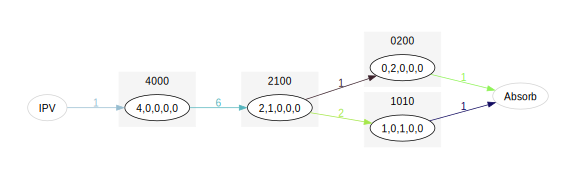

In [18]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

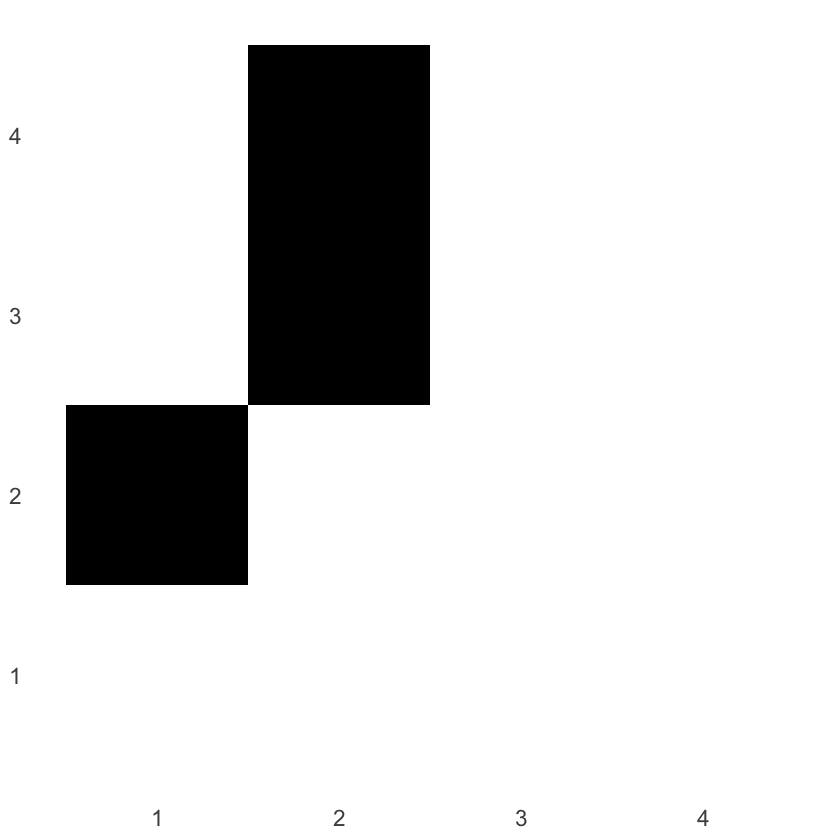

In [19]:
plot_sim(graph)

### Epoque 2

In [20]:
x <- stop_probability(graph, epoques[epoque_nr+1])
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoques[epoque_nr+1])
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
epoque_trans_rates

[1] 0.01464782 0.31297641 1.33103636 1.33103636

In [21]:
epoque_nr <- epoque_nr + 1
add_epoque(n_samples, pop_sizes[epoque_nr], graph, epoque_trans_rates, epoque_nr)

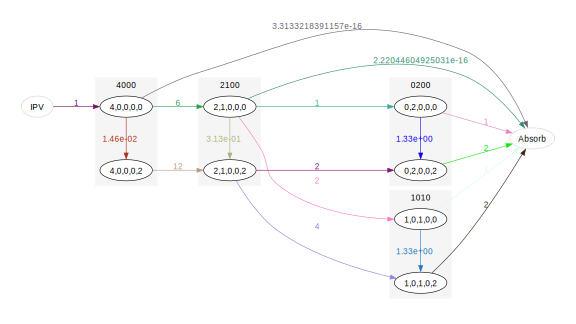

In [22]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

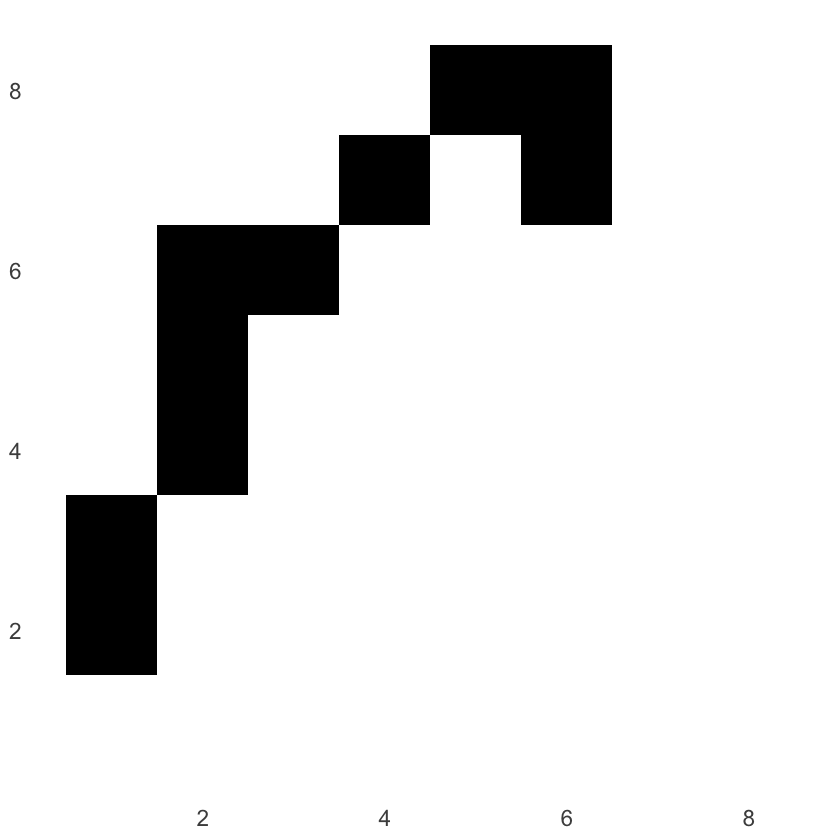

In [23]:
plot_sim(graph)

### Epoque 3

In [24]:
x <- stop_probability(graph, epoques[epoque_nr+1])
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoques[epoque_nr+1])
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
epoque_trans_rates

[1] 3.463800e-05 9.657558e-03 1.023142e-01 1.023142e-01          NaN
[6] 6.944554e-05 2.059860e-02 3.136225e-01 3.136225e-01

In [25]:
epoque_nr <- epoque_nr + 1
add_epoque(n_samples, pop_sizes[epoque_nr], graph, epoque_trans_rates, epoque_nr)

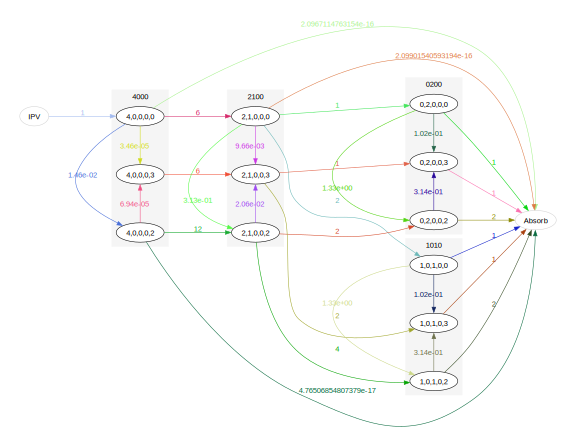

In [26]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

### Moments

In [224]:
moments(graph, 5)

[1]  1.442566  2.709696  6.744565 22.453097 98.418993

In [225]:
mine <- moments(graph, 5)
print(paste(mine, collapse=', '))

[1] "1.44256552841948, 2.70969637947026, 6.74456509090493, 22.4530965967532, 98.4189929341662"


In [226]:
janek <- c(8.807791589074768, 177.8449395799212, 5388.12207361224, 216313.46645481227, 10829024.877199283)
(mine - janek) / janek

[1] -0.8362171 -0.9847637 -0.9987483 -0.9998962 -0.9999909

### SFS

For time inhom:

In [227]:
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

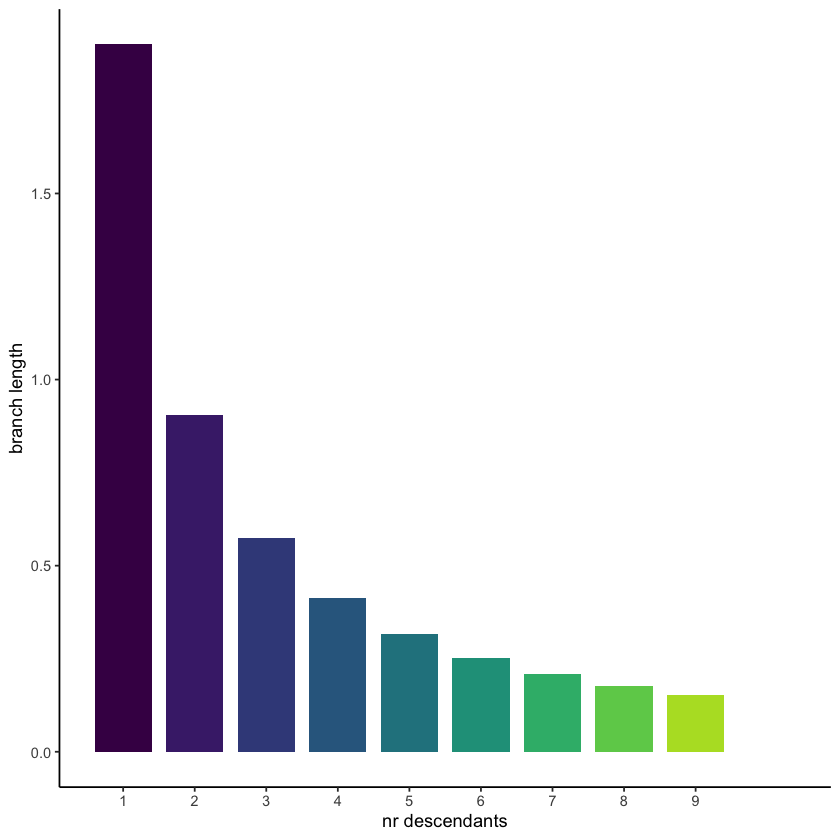

In [228]:
plot_sfs(graph, rewards) + labs(y = "branch length", x = "ton") +  
                  scale_x_continuous(breaks = 1:9)+ theme(legend.position = "none") + labs(x='nr descendants')

Using dist context:

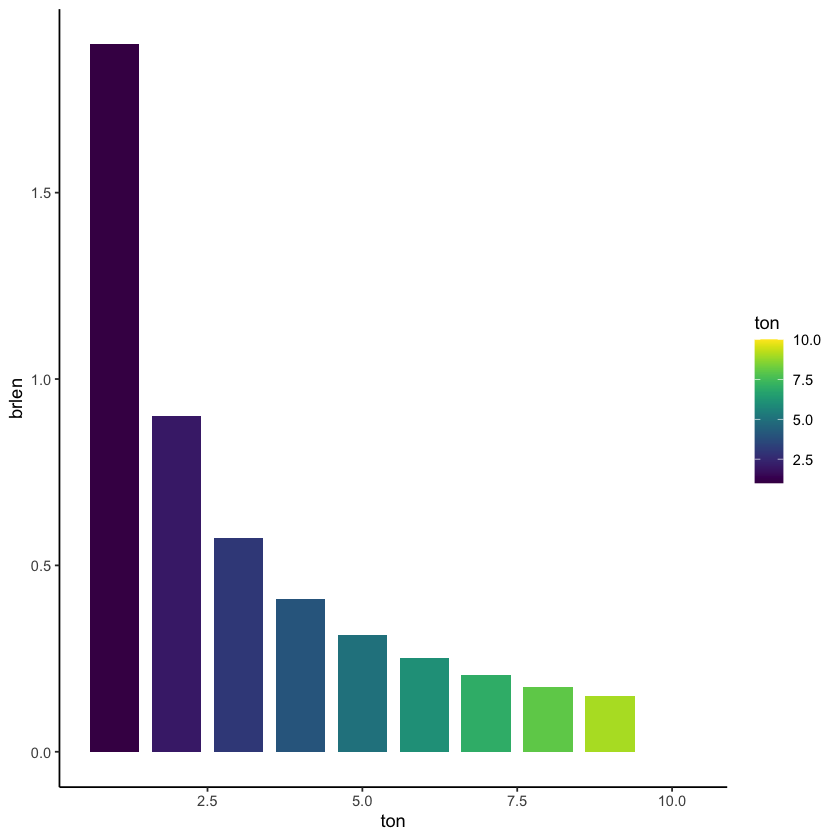

In [229]:
distr_cont_graph <- standard_coalescent(n_samples, 1)
rewards <- sapply(1:vertices_length(distr_cont_graph), function(index) vertex_at(distr_cont_graph, index)$state )

tmrca_pdf <- c()
time <- c()

#ctx <- distribution_context(distr_cont_graph, 1000)
ctx <- distribution_context(distr_cont_graph)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
    time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
    
    size <- pop_sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
    if (size != prev_size) {
        graph_update_weights_parameterized(distr_cont_graph, c(1/size))
    }
    prev_size <- size
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- c()
for (i in 1:(dim(rewards)[1]-1)) {
    sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
}
data.frame(ton=seq(1,length(sfs)), brlen=sfs) %>%
ggplot(aes(x=ton, y=brlen, fill=ton)) + 
  geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + despine

Ok:

For time inhom we can compute

- tobias work:
    - tmrca PDF using dist context
    - marginal expectations
- my work:
    - all tmrca and marginal moments + cross moments

The thing is, there are many time-inhom pdfs that have the same moments. So moments alone cannot be used to fit a popgen model...

But is it of any use to know what the 

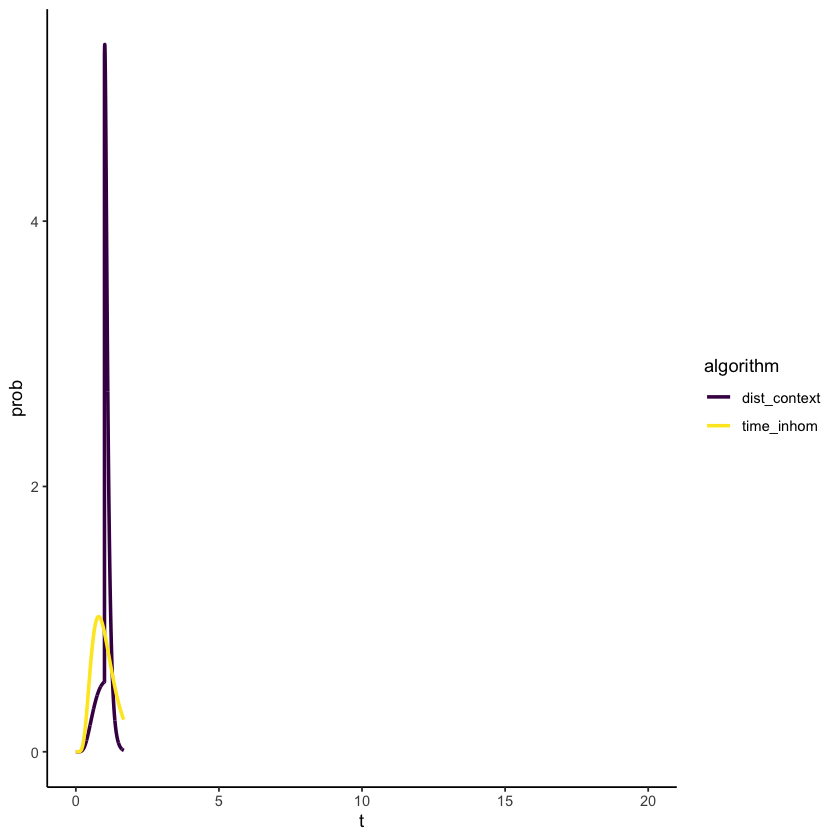

In [212]:
df <- data.frame(prob = unlist(tmrca_pdf), t=unlist(time), algorithm='dist_context')
x <- seq(from = 0, to = max(df$t), by = 0.01)
plot_df <- rbind(df, data.frame(prob = dph(x, graph), t=x, algorithm='time_inhom'))
options(warn=-1)
    ggplot(plot_df, aes(y=prob, x=t, color=algorithm, style=algorithm)) + 
        geom_line(linewidth=1) + 
        scale_color_viridis_d() + 
        despine + xlim(0, 20)
options(warn=0)

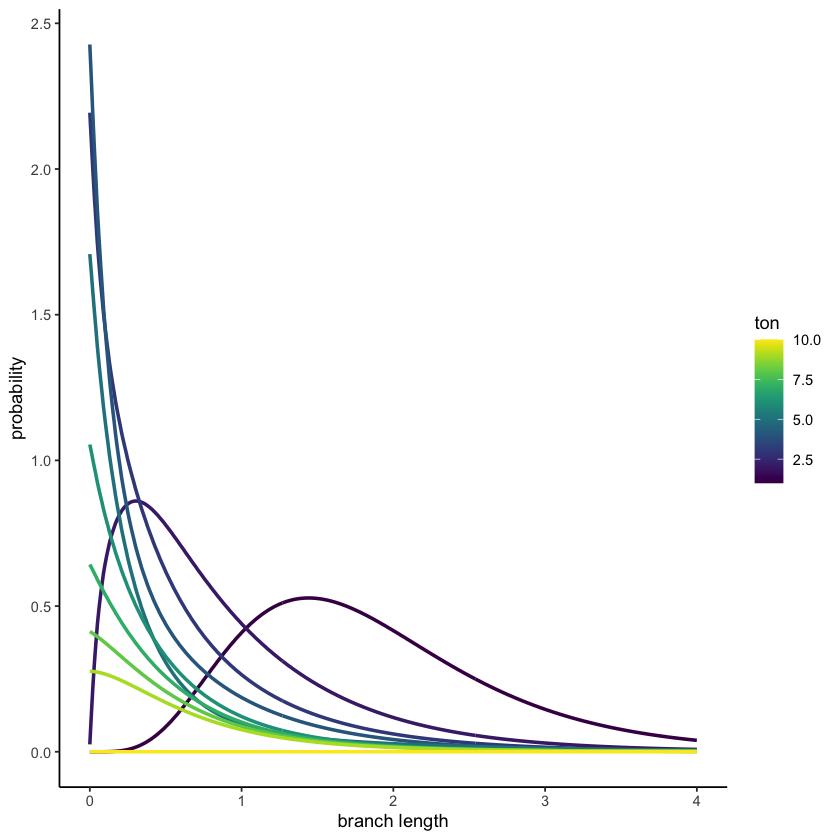

In [230]:
marginal_rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
plot_sfs_dph(graph, marginal_rewards) + labs(x = "branch length")

## Generate state space in c

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

library(tidyverse)
library(devtools)
remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")

#remove.packages("ptdalgorithms")
#devtools::install_github("kaspermunch/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)

library(ptdalgorithms)

source("plot_functions.R")

theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

Indlæser krævet pakke: viridisLite

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Removing package from ‘/Users/kmt/miniconda3/envs/phasetype/lib/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/Rtmpz59EhY/filede8d31dd4ed2/PtDAlgorithms/DESCRIPTION’ (410ms)
─  preparing ‘ptdalgorithms’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘ptdalgorithms_1.0.0.tar.gz’
   


In [2]:
n_samples <- 2

In [3]:
Rcpp::sourceCpp("./timeinhom-kingman.cpp", 
                # verbose=TRUE,
                # rebuild = TRUE
               )

In [4]:
graph <- kingman_graph(n_samples, c(1))

In [5]:
stop_probability(graph, 1)

[1] 0.0000000 0.3676997 0.0000000

In [6]:
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.6326593 0.0000000

In [7]:
add_epoque(graph, c(1/5), 1)
graph_as_matrix(graph)

ERROR: Error in add_epoque(graph, c(1/5), 1): could not find function "add_epoque"


In [22]:
# IF I CONVERT TO MATRIX AND BACK AGAIN, I GET THE RIGHT STOP PROBABILITIES.
# MAYBE BECAUSE MEMORY GETS REALLOCATED COVERING A MEMORY MISTAKE I MADE...
# gam <- graph_as_matrix(graph)
# graph <- matrix_as_graph(gam$IPV, gam$SIM)

In [23]:
stop_probability(graph, 1)

[1] 0.0000000 0.2054774 0.2580455 0.0000000

In [24]:
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.5026824 0.1702287 0.0000000

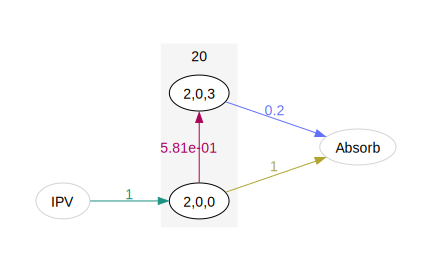

In [14]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [20]:
add_epoque(graph, c(1/10), 2)
graph_as_matrix(graph)

2,0,0
2,0,3
2,0,5
-1.737514,0.581197,0.156317
0.000000,NaN,NaN
0.000000,0.000000,-0.100000


In [ ]:
add_epoque(graph, c(100), 3)
add_epoque(graph, c(200), 4)
add_epoque(graph, c(300), 5)
add_epoque(graph, c(400), 6)
add_epoque(graph, c(500), 7)
graph_as_matrix(graph)

In [8]:
#plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 8))
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

ERROR: Error in if ((i != j) && (gam$SIM[i, j] > 0)) {: manglende værdi hvor TRUE/FALSE er krævet


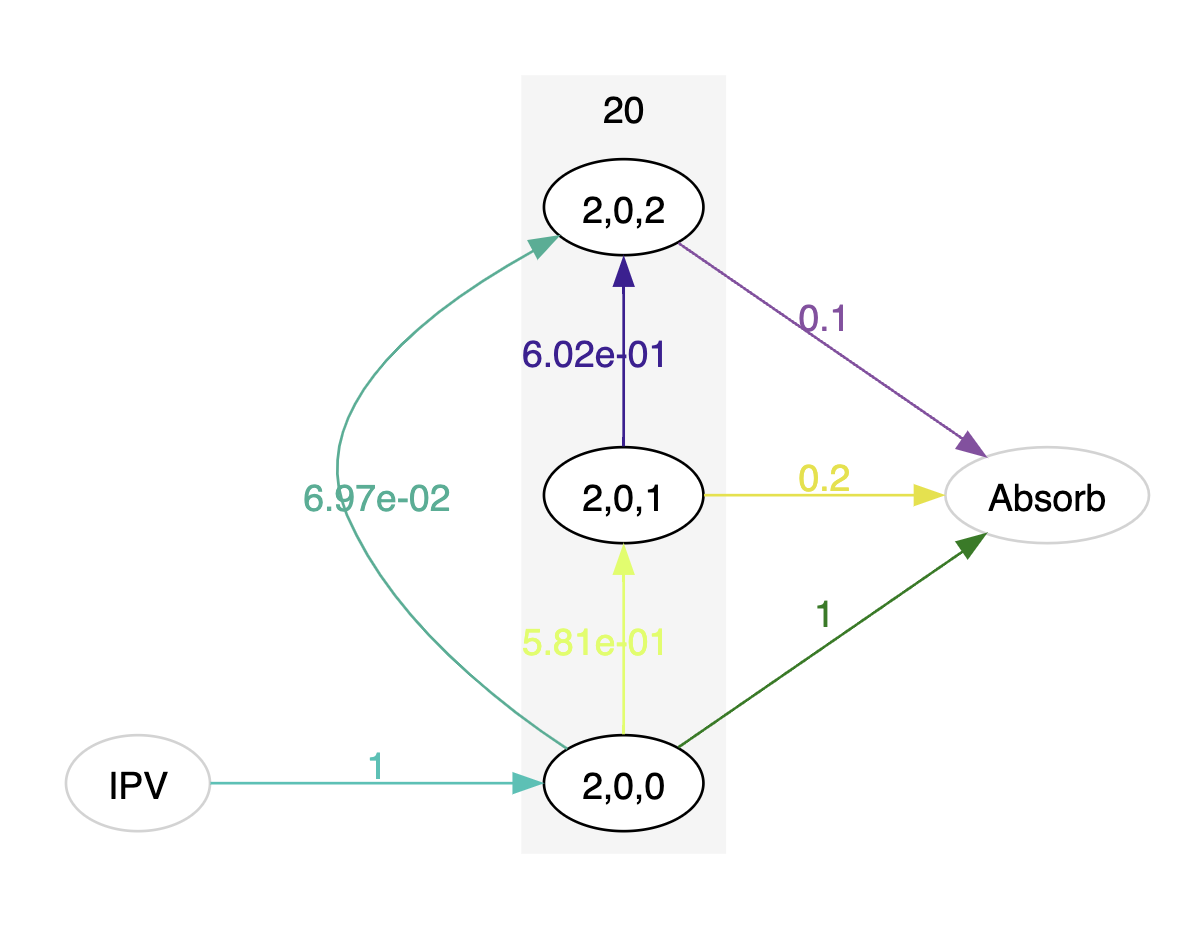

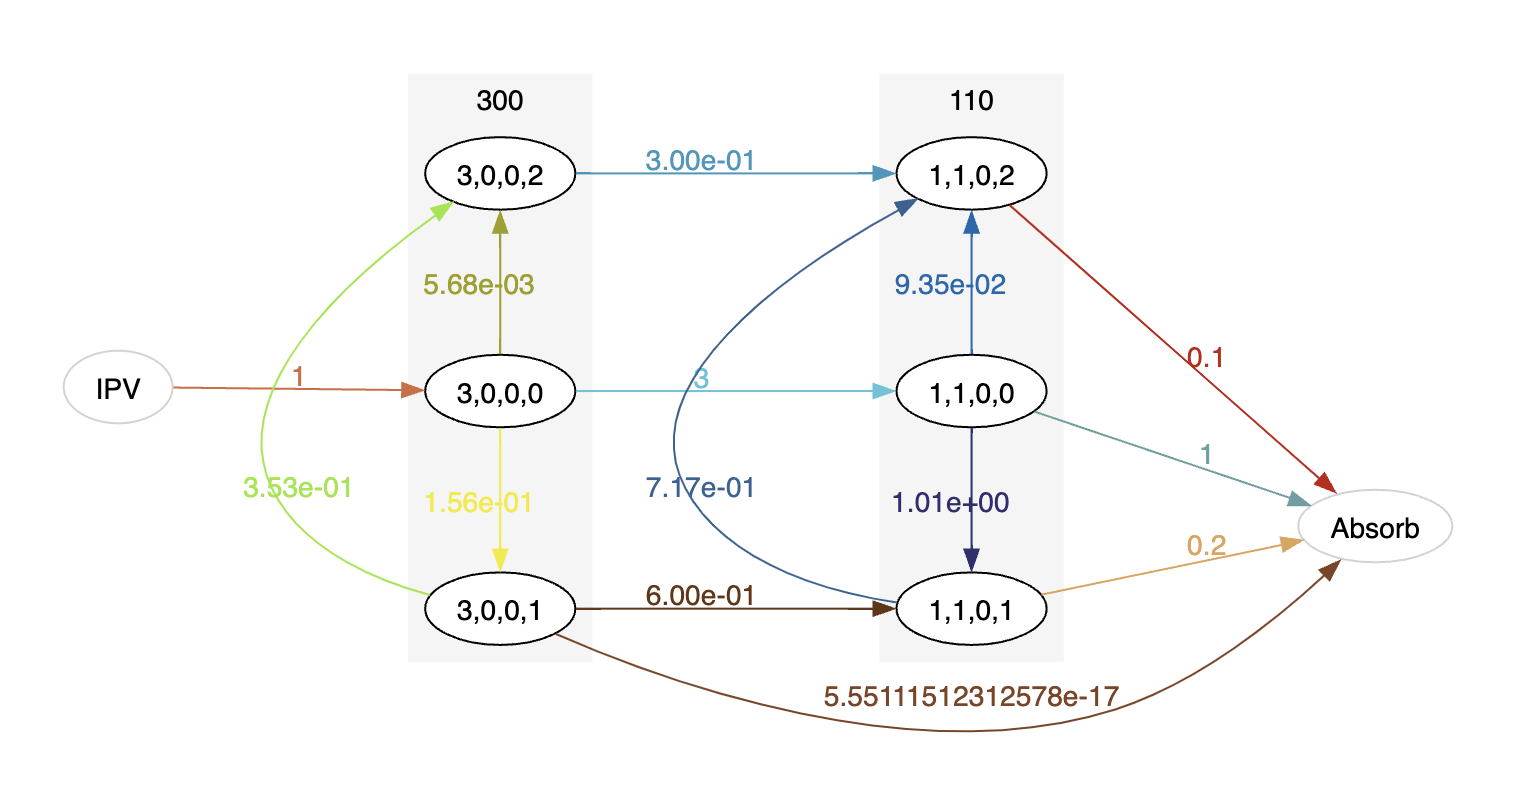

In [134]:
graph_as_matrix(graph)

2,0,0
2,0,3
2,0,4
-1.312634,0.156317,0.156317
0.000000,NaN,NaN
0.000000,0.000000,-0.100000


In [51]:
gam <- graph_as_matrix(graph)
c(length(gam$indices), max(gam$indices)-min(gam$indices)+1)

[1] 3 5

In [126]:
moments(graph, 5)

[1] 0.4608431 0.4094141 0.5354350 0.9241642 1.9824427

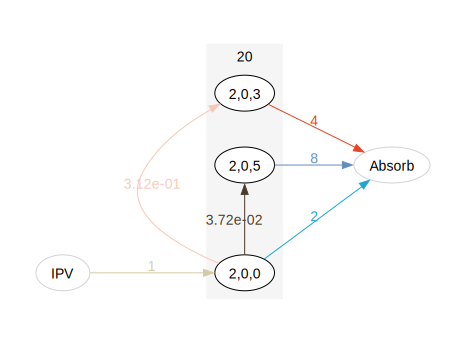

In [127]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))
#plot_graph(gam, subgraphs=TRUE, size=c(8, 8))